# Classifier example

One of the most common uses for neural networks is as a classifier, where input data is mapped to a series of classes, usually as a probability distribution. This is particularly useful if we have access to a number of examples of a particular class, for example a series of images that contain cats and a series of images that do not contain any cats. In this case it is clear to see that defining a closed form expression for whether an image contains a cat would be difficult, thus we wish to implicitly learn the relationship from the data.

In this example, we will construct a network that is looking to classify whether a particular type of anomaly is occurring in our signal of interest. The likelihood of the signal occurring in the dataset will be mapped to a single output, where a higher value indicates a higher likelihood of the anomaly having occurred. 

In [1]:
# import the relevant libraries
import itertools

import matplotlib.pyplot as plt
import numpy as np

from moku.nn import LinnModel, save_linn

# set the seed for repeatability
np.random.seed(42)

# Data generation

For this example, we will use the serial input mode of the neural network instrument. This mode corresponds to taking a rolling window of points from a single input channel which are fed into the model as a single input vector. The maximum input size we can take is a vector of length 100, thus, we will generate a series of signals of length 100. The anomaly that we will try to classify will look like a plateau in an otherwise periodic signal with some noise. 

We will start by generating a series of clean signals that we will inject random anomalies into.

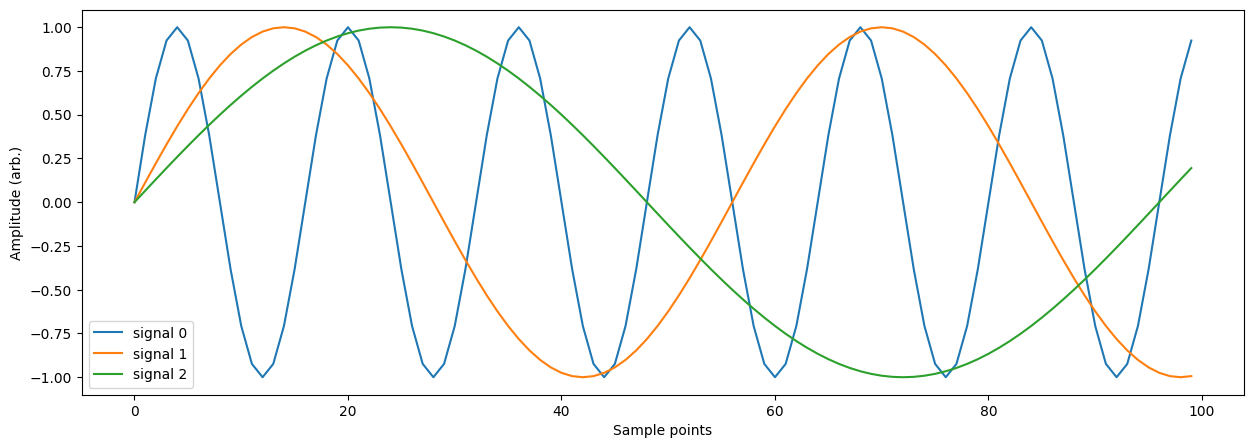

In [2]:
# length of the input signal
N = 100

# time series over which to define the signals
T = np.array([t for t in range(N)])

# a range of phases and frequencies to generate signals over
P = [2 * p for p in range(N // 2)]
OO = np.pi / np.array([o for o in range(8, 64)])

# a range of widths for our signal anomaly
dT = np.array([10 + dt for dt in range(22)])

# create all the signals
signals = []
for o, p in list(itertools.product(OO, P)):
    s = np.sin(o * (T + p))
    signals.append(s)

# view some of the signals so we get a sense of what we're generating
plt.figure(figsize=(15, 5))
count_signals = 0
for i in range(0, len(signals), 1000):
    plt.plot(signals[i], label=str('signal ' + str(count_signals)))
    count_signals += 1

plt.xlabel('Sample points')
plt.ylabel('Amplitude (arb.)')
plt.legend()
plt.show()

Using these signals we will create two classes: defective and non-defective, corresponding to a signal containing an anomaly or no anomaly respectively. We will generate a few examples of each phase and frequency combination we generated earlier with different anomalies and noise. As we are not triggering the acquisition we will assume that the anomaly could occur anywhere in the signal.

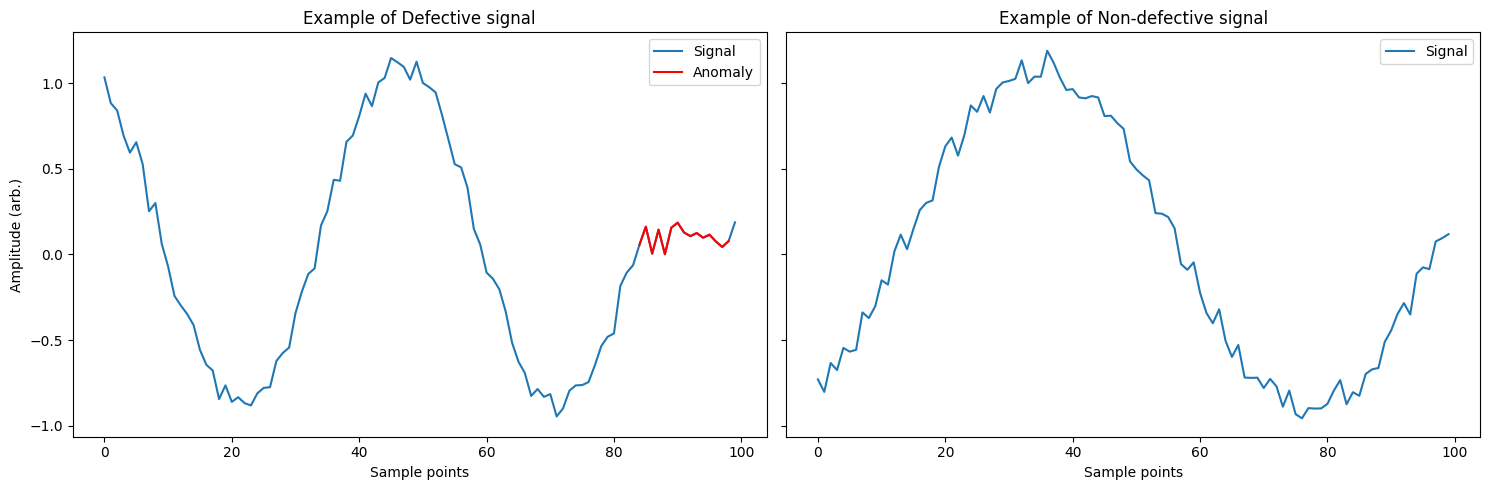

In [3]:
# list to hold all the signals with defect
sigs_dfct = []
for i in range(2):
    # make a copy so we don't modify the original and then shuffle it
    sig1 = np.copy(signals)
    np.random.shuffle(sig1)

    # for each signal in the list, modify it to have an anomaly and noise
    for s in sig1:
        # choose a starting index and width
        start_idx = np.random.choice(T, replace=True)
        dt = np.random.choice(dT, replace=True)

        # clip to the bounds of the array
        if start_idx + dt >= N:
            start_idx = N - dt

        # create an array of indicies that we will modify
        idxs = np.array([start_idx + d for d in range(dt)])
        idxs = idxs[idxs < N]

        # set all the indices to the same value as the anomaly
        s[idxs] = s[start_idx]

        # flip the symmetry of the anomaly on the second iteration
        if i == 1:
            s[idxs] = s[idxs[-1]]

        # create some noise and add it to the signal
        noise = np.random.rand(N) * 0.2
        sigs_dfct.append(s + noise)

# create some non-defective signals with noise
sigs_non = []
for i in range(2):
    # copy the signals to avoid modification
    sig1 = np.copy(signals)
    np.random.shuffle(sig1)

    # add the noise and store them
    for s in sig1:
        noise = np.random.rand(N) * 0.2
        sigs_non.append(s + noise)

# plot an example of what we just created
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].plot(sigs_dfct[-1])
ax[0].plot(range(idxs[0], idxs[-1]), sigs_dfct[-1][idxs[0] : idxs[-1]], 'r')
ax[0].legend(['Signal', 'Anomaly'])
ax[0].set_xlabel('Sample points')
ax[0].set_ylabel('Amplitude (arb.)')
ax[0].set_title('Example of Defective signal')

plt.plot(sigs_non[0])
ax[1].legend(['Signal'])
ax[1].set_xlabel('Sample points')
ax[1].set_title('Example of Non-defective signal')
plt.tight_layout()
plt.show()

We will use these signals now to construct the training data. We need to assign the labels correctly to the different classes where 0 corresponds to non-defective and 1 corresponds to defective. We will also have reserve 10% of the data for validation of the model performance.

In [4]:
# construct the arrays, we will use half of them
X = np.concatenate([sigs_non[: len(sigs_non) // 2], sigs_dfct[: len(sigs_non) // 2]], axis=0)
y = np.concatenate([np.zeros(len(sigs_non) // 2), np.ones(len(sigs_non) // 2)], axis=0)

# shuffle the arrays to avoid training bias
random_idx = [i for i in range(len(y))]
np.random.shuffle(random_idx)
X = X[random_idx]
y = y[random_idx].reshape(-1, 1)

# get 10% of the random indices for the validation set
data_indices = np.arange(0, len(X), 1)
np.random.shuffle(data_indices)
val_length = int(len(X) * 0.1)
train_indices = data_indices[val_length:]
val_indices = data_indices[:val_length]

# separate the training and validation sets
train_X = X[train_indices]
train_y = y[train_indices]
val_X = X[val_indices]
val_y = y[val_indices]

# Model definition and training

Now that we have generated the training data we need to construct our model. As usual we will do this using the provided quantised model class. For this model we will be mapping the 100 length vector input to a single output which has the tanh activation function. The tanh function will act similarly to the the classical sigmoid function, but in this case allows us scale our outputs to the range `[-1, 1]` which is the scaling used by the quantised model. We will also use 4 intermediate layers of reducing size to perform the classification, with each layer having a ReLU activation function.

We will train this model for up to 1000 epochs and configure an early stopping setup to stop when the model training loss plateaus.

In [5]:
# instantiate the quantised model and set the training data
quant_mod = LinnModel()
quant_mod.set_training_data(training_inputs=train_X, training_outputs=train_y)

# define the model architecture and construct it.
model_definition = [(80, 'relu'), (64, 'relu'), (64, 'relu'), (32, 'relu'), (1, 'tanh')]
quant_mod.construct_model(model_definition, show_summary=True, loss='mse')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer               │ (None, 80)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_1             │ (None, 64)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_2             │ (None, 64)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_3             │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_4             │ (None, 1)              │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,537 (76.32 KB)

 Trainable params: 19,537 (76.32 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Kick off the training
es_config = {'monitor': 'loss', 'patience': 100, 'restore': True}
history = quant_mod.fit_model(epochs=1000, validation_data=(val_X, val_y), es_config=es_config)

Epoch 1/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9437 - val_loss: 0.3946
Epoch 2/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6927 - val_loss: 0.3274
Epoch 3/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5323 - val_loss: 0.3295
Epoch 4/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4516 - val_loss: 0.3718
Epoch 5/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3932 - val_loss: 0.3913
Epoch 6/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3526 - val_loss: 0.4201
Epoch 7/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3124 - val_loss: 0.4334
Epoch 8/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2824 - val_loss: 0.4723
Epoch 9/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2761 - val_loss: 0.4604
Epoch 10/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2728 - val_loss: 0.4143
Epoch 11/1000
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2551 - val_loss: 0.4476
Epoch 12/1000
158/158 ━━━━━━━━

We can view the training losses to determine whether the model is performing as expected.

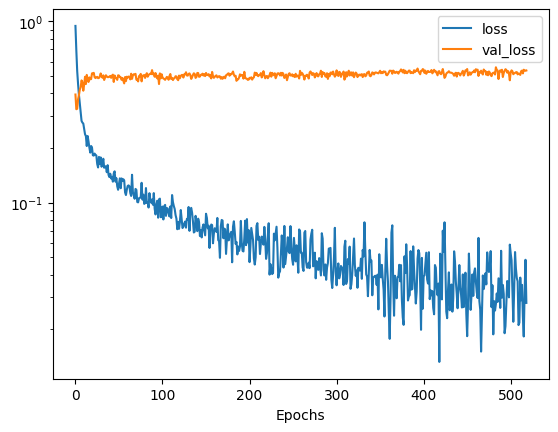

In [7]:
# Plot the relevant losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

We can view the accuracy of the model by rounding the predictions to effectively threshold a binary outcome around 0.5. To see the actual distribution of the the outputs plot a distribution of the outputs for both the training and validation predictions.

In [8]:
def get_accuracy(y_true, y_pred):
    # round up/down to get a binary prediction. This could be modified with different thresholds
    rounded_y_pred = np.round(y_pred)

    # find the accuracy py finding when the difference is 0
    diff = y_true - rounded_y_pred
    return np.array(diff == 0, dtype=int).sum() / len(diff)

In [9]:
# get the training predictions
preds = quant_mod.predict(train_X)
y_train_acc = get_accuracy(train_y, preds) * 100

# get the validation predictions
preds_val = quant_mod.predict(val_X)
y_val_acc = get_accuracy(val_y, preds_val) * 100

print(
    '-' * 10
    + ' Model Accuracy '
    + '-' * 10
    + '\nTrain: \t %.2f %%' % y_train_acc
    + '\nVal: \t %.2f %%\n' % y_val_acc
    + '-' * 36
)

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
---------- Model Accuracy ----------
Train: 	 99.78 %
Val: 	 95.71 %
------------------------------------


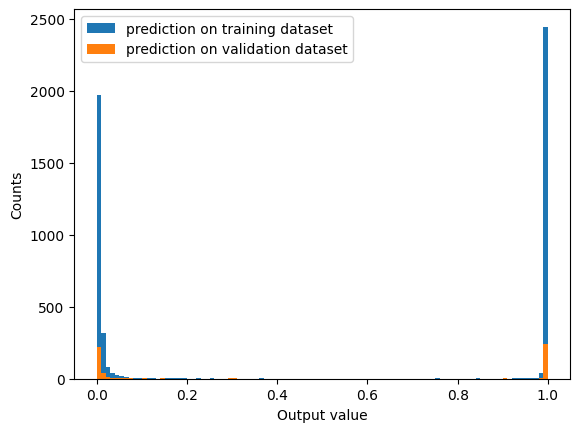

In [10]:
# plot a histogram of all the predictions
plt.hist(preds, bins=np.linspace(0, 1, 101), label='prediction on training dataset')
plt.hist(preds_val, bins=np.linspace(0, 1, 101), label='prediction on validation dataset')
plt.ylabel('Counts')
plt.xlabel('Output value')
plt.legend()
plt.show()

Test the model on unseen data (data not used in training). 

As the training and validation sets were created using half of the datapoints generated at the beginning of the script, we'll use the second half to test the model on unseen dat.

In [11]:
# construct the arrays, we will use the second half of the original signals
X_test = np.concatenate([sigs_non[len(sigs_non) // 2 :], sigs_dfct[len(sigs_non) // 2 :]], axis=0)
y_test = np.concatenate([np.zeros(len(sigs_non) // 2), np.ones(len(sigs_non) // 2)], axis=0)

# shuffle the arrays to avoid training bias
random_idx_test = [i for i in range(len(y_test))]
np.random.shuffle(random_idx_test)
X_test = X_test[random_idx_test]
y_test = y_test[random_idx_test].reshape(-1, 1)

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
---------- Model Accuracy ----------
Train: 	 95.00 %


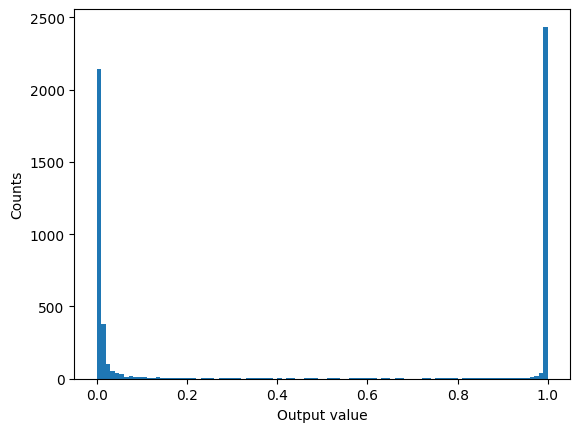

In [12]:
# get the training predictions
preds_test = quant_mod.predict(X_test)
y_test_acc = get_accuracy(y_test, preds_test) * 100

print('-' * 10 + ' Model Accuracy ' + '-' * 10 + '\nTrain: \t %.2f %%' % y_test_acc)

# plot a histogram of all the predictions
plt.hist(preds_test, bins=np.linspace(0, 1, 101))
plt.ylabel('Counts')
plt.xlabel('Output value')
plt.show()

In [13]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='classifier.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 10 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 355 cycles
